In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from functools import reduce
import numpy as np
import torch
import torch.nn as nn
from layers.customLayer import CustomLayer
from training.train import TrainUtil
from metrics.charts import ChartUtil
from metrics.charts import TrainingCharts

In [3]:
def xor(x):
    return reduce(lambda a, b: a ^ b, x)

batch_size = 200
in_features = 2
X = np.random.randint(0, 2, size=(batch_size, in_features))
y = np.array([xor(x) for x in X])

X = torch.tensor(X).float()
y = torch.tensor(y).long()

In [4]:
trainUtil = TrainUtil(X, y, 100)

In [5]:
first_layer_out_features = 200
first_layer_out_features_allowed = 15
second_layer_out_features = 250
second_layer_out_features_allowed = 20
third_layer_out_features = 200
third_layer_out_features_allowed = 10

class SimpleSparseModel(nn.Module):
    def __init__(self, in_features = in_features, out_features = 2):
        super().__init__()
        self._layer1 = CustomLayer(in_features, 
                                        first_layer_out_features, 
                                        out_features_allowed=first_layer_out_features_allowed)
        self._layer2 = CustomLayer(first_layer_out_features, 
                                        second_layer_out_features, 
                                        out_features_allowed=second_layer_out_features_allowed)
        self._layer3 = CustomLayer(second_layer_out_features, 
                                        third_layer_out_features, 
                                        out_features_allowed=third_layer_out_features_allowed)
        self._layer4 = CustomLayer(third_layer_out_features, out_features)

    def forward(self, x, return_acts = False):
        x_l1 = self._layer1(x)
        x_l2 = self._layer2(x_l1)
        x_l3 = self._layer3(x_l2)
        out = self._layer4(x_l3)
        if return_acts:
            return out, {"l1": x_l1, "l2": x_l2, "l3": x_l3, "l4": out}
        return out
    
class SimpleControlModel(nn.Module):
    def __init__(self, in_features = in_features, out_features = 2):
        super().__init__()
        self._layer1 = CustomLayer(in_features, first_layer_out_features_allowed)
        self._layer2 = CustomLayer(first_layer_out_features_allowed, second_layer_out_features_allowed)
        self._layer3 = CustomLayer(second_layer_out_features_allowed, third_layer_out_features_allowed)
        self._layer4 = CustomLayer(third_layer_out_features_allowed, out_features)

    def forward(self, x, return_acts = False):
        x_l1 = self._layer1(x)
        x_l2 = self._layer2(x_l1)
        x_l3 = self._layer3(x_l2)
        out = self._layer4(x_l3)
        if return_acts:
            return out, {"l1": x_l1, "l2": x_l2, "l3": x_l3, "l4": out}
        return out
    
class SimpleDenseModel(nn.Module):
    def __init__(self, in_features = in_features, out_features = 2):
        super().__init__()
        self._layer1 = CustomLayer(in_features, first_layer_out_features)
        self._layer2 = CustomLayer(first_layer_out_features, second_layer_out_features)
        self._layer3 = CustomLayer(second_layer_out_features,third_layer_out_features)
        self._layer4 = CustomLayer(third_layer_out_features, out_features)
        nn.Linear(in_features, out_features).forward
        self.net = nn.Sequential(
            self._layer1,
            self._layer2,
            self._layer3,
            self._layer4
        )

    def forward(self, x):
        return self.net(x)

In [6]:
simpleSparseModel = SimpleDenseModel()
trainUtil.train_and_evaluate(simpleSparseModel, epochs=50, print_msg=True)

Epoch 0, Loss: 0.7358
Epoch 10, Loss: 0.0063
Epoch 20, Loss: 0.6123
Epoch 30, Loss: 0.2281
Epoch 40, Loss: 0.7148
Model Train Accuracy: 56.0000, Val Accuracy: 48.0000


([0.735827624797821,
  0.00629987521097064,
  0.6122534871101379,
  0.2281065285205841,
  0.7147708535194397],
 [56.00000023841858,
  43.99999976158142,
  43.99999976158142,
  43.99999976158142,
  56.00000023841858],
 [0, 10, 20, 30, 40],
 56.00000023841858,
 47.999998927116394)

In [16]:
chartUtil = ChartUtil()
epoch_num = 41
for i in range(60):
    simpleSparseModel = SimpleSparseModel()
    loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseModel, epochs=epoch_num, name="Sparse Model")
    chartUtil.add_train_data("Sparse Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Sparse Model", train_accuracy, val_accuracy)

    simpleSparseOrthoModel = SimpleSparseModel()
    loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseOrthoModel, epochs=epoch_num, name="Sparse Ortho Model", ortho_lambda=0.1)
    chartUtil.add_train_data("Sparse Ortho Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Sparse Ortho Model", train_accuracy, val_accuracy)

    simpleControlModel = SimpleControlModel()
    loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleControlModel, epochs=epoch_num, name="Control Model")
    chartUtil.add_train_data("Control Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Control Model", train_accuracy, val_accuracy)

    simpleDenseModel = SimpleDenseModel()
    loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleDenseModel, epochs=epoch_num, name="Dense Model")
    chartUtil.add_train_data("Dense Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Dense Model", train_accuracy, val_accuracy)

Sparse Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Ortho Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Control Model Train Accuracy: 44.0000, Val Accuracy: 52.0000
Dense Model Train Accuracy: 56.0000, Val Accuracy: 48.0000
Sparse Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Ortho Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Control Model Train Accuracy: 56.0000, Val Accuracy: 48.0000
Dense Model Train Accuracy: 44.0000, Val Accuracy: 52.0000
Sparse Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Ortho Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Control Model Train Accuracy: 44.0000, Val Accuracy: 52.0000
Dense Model Train Accuracy: 44.0000, Val Accuracy: 52.0000
Sparse Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Ortho Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Control Model Train Accuracy: 68.0000, Val Accuracy: 78.0000
Dense Model Train Accuracy: 56.0000, Val Accuracy: 48.0000


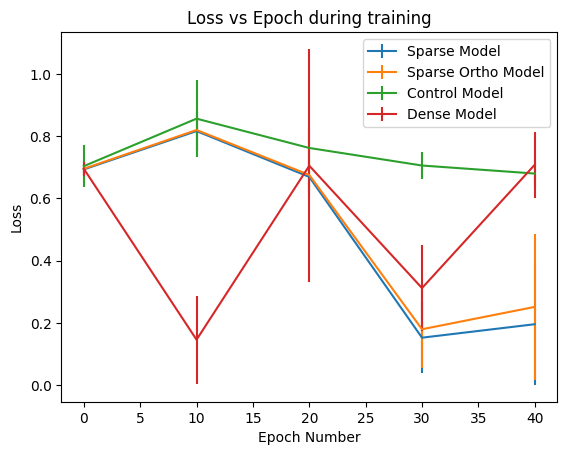

In [17]:
chartUtil.plot_training_data_for()

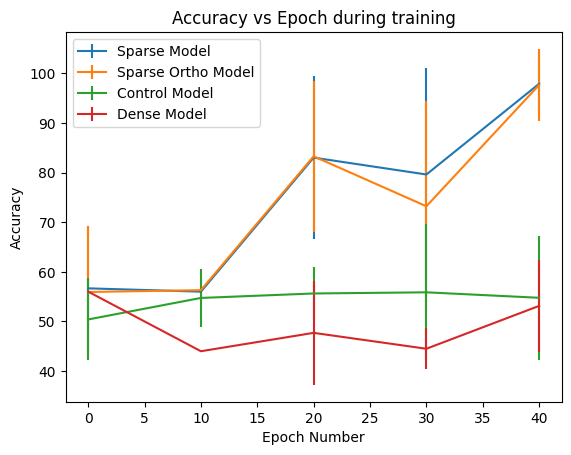

In [20]:
chartUtil.plot_training_data_for(TrainingCharts.ACC)

In [113]:
model1Final = chartUtil.data["test"]["Sparse Ortho Model"]["train_acc"]
model2Final = chartUtil.data["test"]["Sparse Model"]["train_acc"]
np.mean(model1Final), np.std(model1Final), np.mean(model2Final), np.std(model2Final)

(np.float64(100.0), np.float64(0.0), np.float64(100.0), np.float64(0.0))

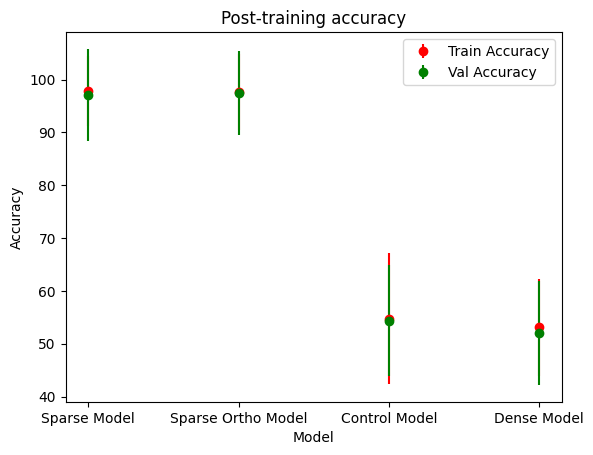

In [19]:
chartUtil.plot_test_accu_for_models()

In [23]:
model = SimpleSparseModel()
trainUtil.train_and_evaluate(model)

model.eval()
random_input_index = 10
random_input = trainUtil.X_val[random_input_index]
random_output = trainUtil.y_val[random_input_index]
# Add batch dimension
input_batch = random_input.unsqueeze(0)
model_layer_1_activations = model._layer1.forward(input_batch)
model_layer_2_activations = model._layer2.forward(model_layer_1_activations)
model_layer_3_activations = model._layer3.forward(model_layer_2_activations)
print("Input: ", random_input)
print("True Output: ", random_output)
print("Model Output layer 1: ", model_layer_1_activations.squeeze(0))
print("Model Output layer 2: ", model_layer_2_activations.squeeze(0))
print("Model Output layer 3: ", model_layer_3_activations.squeeze(0))

model.train()

Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Input:  tensor([0., 0.])
True Output:  tensor(0)
Model Output layer 1:  tensor([0.2759, 0.3314, 0.6607, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.4641, 0.5095, 0.5032, 0.0000, 0.6679, 0.6970],
       grad_fn=<SqueezeBackward1>)
Model Output layer 2:  tensor([ 0.0000,  0.6301,  1.0698,  0.0000, -0.0159,  0.8362,  0.0000,  0.0000,
         0.0170,  1.0947,  0.0000,  0.0000,  0.0000,  0.7743,  1.4611,  0.0000,
         0.5703,  0.0000,  0.0000, -0.0042], grad_fn=<SqueezeBackward1>)
Model Output layer 3:  tensor([ 2.0546, -0.0499], grad_fn=<SqueezeBackward1>)


SimpleSparseModel(
  (_layer1): CustomLayer(
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (_layer2): CustomLayer(
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (_layer3): CustomLayer(
    (activation): LeakyReLU(negative_slope=0.1)
  )
)

In [ ]:
chartUtil = ChartUtil()
for i in range(5):
    simpleSparseModel = SimpleSparseModel()
    loss_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseModel, epochs=50, name="Sparse Model")
    chartUtil.add_train_data("Sparse Model", loss_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Sparse Model", train_accuracy, val_accuracy)

    simpleSparseOrthoModel = SimpleSparseModel()
    loss_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseOrthoModel, epochs=50, name="Sparse Ortho Model", ortho_lambda=0.1)
    chartUtil.add_train_data("Sparse Ortho Model", loss_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Sparse Ortho Model", train_accuracy, val_accuracy)

    simpleControlModel = SimpleControlModel()
    loss_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleControlModel, epochs=50, name="Control Model")
    chartUtil.add_train_data("Control Model", loss_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Control Model", train_accuracy, val_accuracy)

    simpleDenseModel = SimpleDenseModel()
    loss_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleDenseModel, epochs=50, name="Dense Model")
    chartUtil.add_train_data("Dense Model", loss_over_epochs, epoch_numbers)
    chartUtil.add_test_data("Dense Model", train_accuracy, val_accuracy)

Sparse Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Sparse Ortho Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Control Model Train Accuracy: 51.0000, Val Accuracy: 52.0000
Dense Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Sparse Model Train Accuracy: 50.0000, Val Accuracy: 52.0000
Sparse Ortho Model Train Accuracy: 53.0000, Val Accuracy: 50.0000
Control Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Dense Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Sparse Ortho Model Train Accuracy: 73.0000, Val Accuracy: 75.0000
Control Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Dense Model Train Accuracy: 73.0000, Val Accuracy: 75.0000
Sparse Model Train Accuracy: 74.0000, Val Accuracy: 75.0000
Sparse Ortho Model Train Accuracy: 100.0000, Val Accuracy: 100.0000
Control Model Train Accuracy: 50.0000, Val Accuracy: 48.0000
Dense Model Train Accuracy: 26.0000, Val Accuracy: 25.0000
Sparse Mod